### 1. Load Raw Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import MotionData as m
import itertools
import FeatureCalculators as ftr
%matplotlib inline



#use the MotionData.py class to load motion data and clean data
motionLoader = m.MotionData('data')
motion = motionLoader.motion
valid_questionnaire = motionLoader.qs
valid_questionnaire['PF'] = valid_questionnaire[['Q3','Q4','Q5','Q6','Q7','Q8','Q9','Q10','Q11','Q12']].mean(axis=1)
#Join valid users from questionnaire with motion dataframe...effectively removing users from the motion dataframe that do not have valid questionnaire data
motion = pd.merge(valid_questionnaire[['user']],motion,on='user',how='left')

### 2. Motion File Processing:

##### 2.1 Users that have uploaded less than 40 hours of movement data (40 hours when phone was not stationary) will be removed
##### f2-28 features will be NAN for hours where NO movement occured (details <a href="featureDescriptions.md">here</a>). We use f2 the count hours of non-NAN values

In [2]:
#Count number of f2 features for each user....using f2 as we want to count number of hours where there was activity. If f2 is NAN then there was no activity
NUM_ACTIVE_DAYS_NEEDED = 4
entryCounts = motion.groupby(by='user').count()[['f2']]
#select users with at least 40 hours of non-stationary motion data
validmotion_Users= entryCounts[entryCounts['f2'] > 8 * NUM_ACTIVE_DAYS_NEEDED].reset_index()
print(f"Motion file has {validmotion_Users.shape[0]} users with at least {8 * NUM_ACTIVE_DAYS_NEEDED} hours of active motion data")


Motion file has 332 users with at least 32 hours of active motion data


#### 2.2 Left join valid user with full motion file...in effect this will remove non valid users from the motion dataframe


In [3]:
validmotion = pd.merge(validmotion_Users['user'],motion,on='user',how='left')
validmotion['day'] = validmotion['datetime'].dt.date

#### 2.3 Apply weighting to measures. The more movement there was for a given hour, the more weight it should hold.

Weights are calculated by evaluating the feature f29 (percentage of time moving per hour)
* A feature 'f29sum' is calculated to calculate total movement for a given day
* A feature 'f29Perc' is calculated such that 'f29Perc' = 'f29' / 'f29sum'
* All features f2 - f28 are then multiplied by the weight
* We do not weight f30-f33 as these are stats related to periods of inactivity


In [4]:
f29Sum = validmotion[['user','day','f29']].groupby(by=['user','day']).agg(f29_daysum=('f29','sum'))
validmotion = pd.merge(validmotion,f29Sum.reset_index(),on=['user','day'],how='left')
validmotion['f29_DayPerc'] = validmotion['f29'] / validmotion['f29_daysum'] 

FMAX = 29
#create a list specifying the columsn that will be weighted
weightColumns = ['f' + str(x) for x in range(2,FMAX)]
#iterate the specified columns are create a new column for each feature called f{n}_weighted = f{n} * f29_DayPerc
for i in range(0,len(weightColumns)):
    validmotion[weightColumns[i] + '_weighted'] = validmotion[weightColumns[i]] * validmotion['f29_DayPerc']

#### 2.4 Group motion file by user and by day....allowing us to compute summary features of motion per day for each user

In [5]:
#to get the weighted mean of the f2-f28 columns, add up the weighted features (sum)
weightColumnNames = ['f' + str(x) + '_weighted' for x in range(2,FMAX)]
dailyMotionAggs_weighted = validmotion.drop('datetime',axis=1).groupby(by=['user','day'])[weightColumnNames].agg('sum')

#to get other standard measures for f2-f33, specifiy the standard agg functions
standardColumnNames = ['f' + str(x) for x in range(2,34)] + ['f29_daysum']
dailyMotionAggs = validmotion.drop(weightColumnNames + ['datetime'],axis=1).groupby(by=['user','day'])[standardColumnNames].agg(['mean','std','min','max'])

# get rid of multi level column names and change to single flat column names which combines level0 and level1 naming
flatCols = dailyMotionAggs.columns.get_level_values(0) + '_' +  dailyMotionAggs.columns.get_level_values(1)
dailyMotionAggs.columns = flatCols

#combine the weighted feature dataframe with the standard agg freature dataframe
dailyMotionAggs = pd.merge(dailyMotionAggs,dailyMotionAggs_weighted,on=['user','day'],how='left').reset_index()


#### 2.5 Identify consecutive days of recorded data. The aim is to find a large number of consecutive days and generate timeseries related features
* DailyMotionAggs now define feature for each user for each day
* Find consecutive days using pandas Timedelta('1d')
* For each day we will assign a "dayseq" id which can be used to group consecutive days together
* We count the number of days in each consecutive day group
* We keep the group that has the most days

In [6]:
#create a mask to define if rows are in consecutive order
dt = dailyMotionAggs['day']
day = pd.Timedelta('1d')
in_block = ((dt - dt.shift(-1)).abs() == day) | (dt.diff() == day)
#filter dataframe based on mast (showing only frames that are in a group of at least 2 consecutive days)
filt = dailyMotionAggs.loc[in_block]
#create another mask to check for when the groups break...i.e. when there is more than 1 day diff between each group
breaks = filt['day'].diff() != day
#assign an ID to each consecutive group of day
groups = breaks.cumsum()
#add group ids into original dataframe
dailyMotionAggs['dayseq'] = groups
#count the number of days in each consecutive group
consecutiveDayCounts = dailyMotionAggs.groupby(by=['dayseq','user'])[['dayseq']].agg(dayseq_count=('dayseq','count'))

#add group_count into original dataframe
dailyMotionAggs = pd.merge(consecutiveDayCounts.reset_index()[['dayseq','dayseq_count']],dailyMotionAggs,on='dayseq',how='left')
#filter out groups with less than 4 consecutive days
dailyMotionAggs = dailyMotionAggs[dailyMotionAggs['dayseq_count'] >= NUM_ACTIVE_DAYS_NEEDED]
#select day sequence that have the most amount of days...where the selected sequence is the one with most consequtive days
idx =consecutiveDayCounts.groupby(['user'])['dayseq_count'].transform(max) == consecutiveDayCounts['dayseq_count']
#join selected dequences with full feature dataframe
dailyMotionAggs_longsestSeq = pd.merge(consecutiveDayCounts[idx].reset_index()[['user','dayseq']],dailyMotionAggs,on=['user','dayseq'],how='left').dropna()


In [7]:
dailyMotionAggs_longsestSeq = dailyMotionAggs_longsestSeq.groupby(by='dayseq').head(10)

#### 2.6 Apply weights to the days in the consecutive day group
* Using f29_daysum (which was calculated in 2.3) for each day, calculate "f29_allsum" which is the sum of all f29_daysums on a consecutive day group
* Calculate f29_AllPerc = f29_daysum / f29_allsum for each day in a consecutive day group
* Calculate f{n}_Allweighted = f{n}_weighted * f29_AllPerc

In [8]:
#merge in the f29_daysum column
dailyMotionAggs_longsestSeq_ = pd.merge(dailyMotionAggs_longsestSeq,f29Sum.reset_index(),on=['user','day'],how='left')
#2. groupby the groups
f29AllSum = dailyMotionAggs_longsestSeq_.groupby(by='user').agg(f29_allsum=('f29_daysum','sum'))
#3. merge the dataframe holding daily feature vectors with the [f29_daysum, f29_allsum] weights dataframe
dailyMotionAggs_allsum = pd.merge(f29AllSum.reset_index(),dailyMotionAggs_longsestSeq_ ,on='user',how='left')
#4. use the [f29_daysum, f29_allsum] weights to calculate a percentage weight for each day (f29_AllPerc)
dailyMotionAggs_allsum['f29_AllPerc'] = dailyMotionAggs_allsum['f29_daysum'] / dailyMotionAggs_allsum['f29_allsum'] 
#5. create a new set of features f{n}_Allweighted = f{n}_weighted * f29_AllPerc
for i in range(0,len(weightColumns)):
    dailyMotionAggs_allsum[weightColumns[i] + '_Allweighted'] = dailyMotionAggs_allsum[weightColumns[i] + '_weighted'] * dailyMotionAggs_allsum['f29_AllPerc']
    
dailyMotionAggs = dailyMotionAggs_allsum

#### 2.7 After computing summary features for each individual day, combine all daily features into an overall feature to summarise motion for each user

* Caculate sum of all f{n}_Allweighted features in order get weighted sum
* Calculat number of features on other features including mean, std, average chage, longest period of time above mean


In [9]:
#to get the weighted mean of the f2-f28 columns, add up the weighted features (sum)
allWeightColumnNames = ['dayseq_count'] + ['f' + str(x) + '_Allweighted' for x in range(2,FMAX)]
summaryMotionAggs_weighted = dailyMotionAggs.drop('day',axis=1).groupby(by=['dayseq','user'])[allWeightColumnNames].agg('sum')

#to get other standard measures for f2-f33, specifiy the standard agg functions
summaryMotionAggs = dailyMotionAggs.drop(allWeightColumnNames + ['day'],axis=1).groupby(by='dayseq').agg(['mean','std','min','max','median',ftr.change,ftr.cid_ce,ftr.longest_strike_above_mean])
flatColsDays = summaryMotionAggs.columns.get_level_values(0) + '_' +  summaryMotionAggs.columns.get_level_values(1)
summaryMotionAggs.columns = flatColsDays

summaryMotionAggs = pd.merge(summaryMotionAggs,summaryMotionAggs_weighted,on='dayseq',how='left')
summaryMotionAggs = summaryMotionAggs.dropna()

summaryMotionAggs =pd.merge(summaryMotionAggs,summaryMotionAggs_weighted.reset_index()[['user','dayseq']],on='dayseq',how='left')

summaryMotionAggs_ = pd.merge(summaryMotionAggs.reset_index(),dailyMotionAggs[['dayseq','user','dayseq_count']],on='user',how='left')
#add user id back into the summaryMotionAggs
summaryMotionQS = pd.merge(summaryMotionAggs,valid_questionnaire,on='user',how='left')
#it is possible that one user could still have more than 1 entery in this dataframe (in the case where there was 2 or more consecutive day group durations that had the max amount of days)
summaryMotionQS = summaryMotionQS.drop_duplicates(subset='user', keep="first").copy()

/tmp/ipykernel_1143/1970015325.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  summaryMotionAggs = pd.merge(summaryMotionAggs,summaryMotionAggs_weighted,on='dayseq',how='left')
/tmp/ipykernel_1143/1970015325.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  summaryMotionAggs =pd.merge(summaryMotionAggs,summaryMotionAggs_weighted.reset_index()[['user','dayseq']],on='dayseq',how='left')


## 3 Motion File Exploritory Analysis
#### 3.1 Investigate Correlations between Result1, Result2 and different motion features


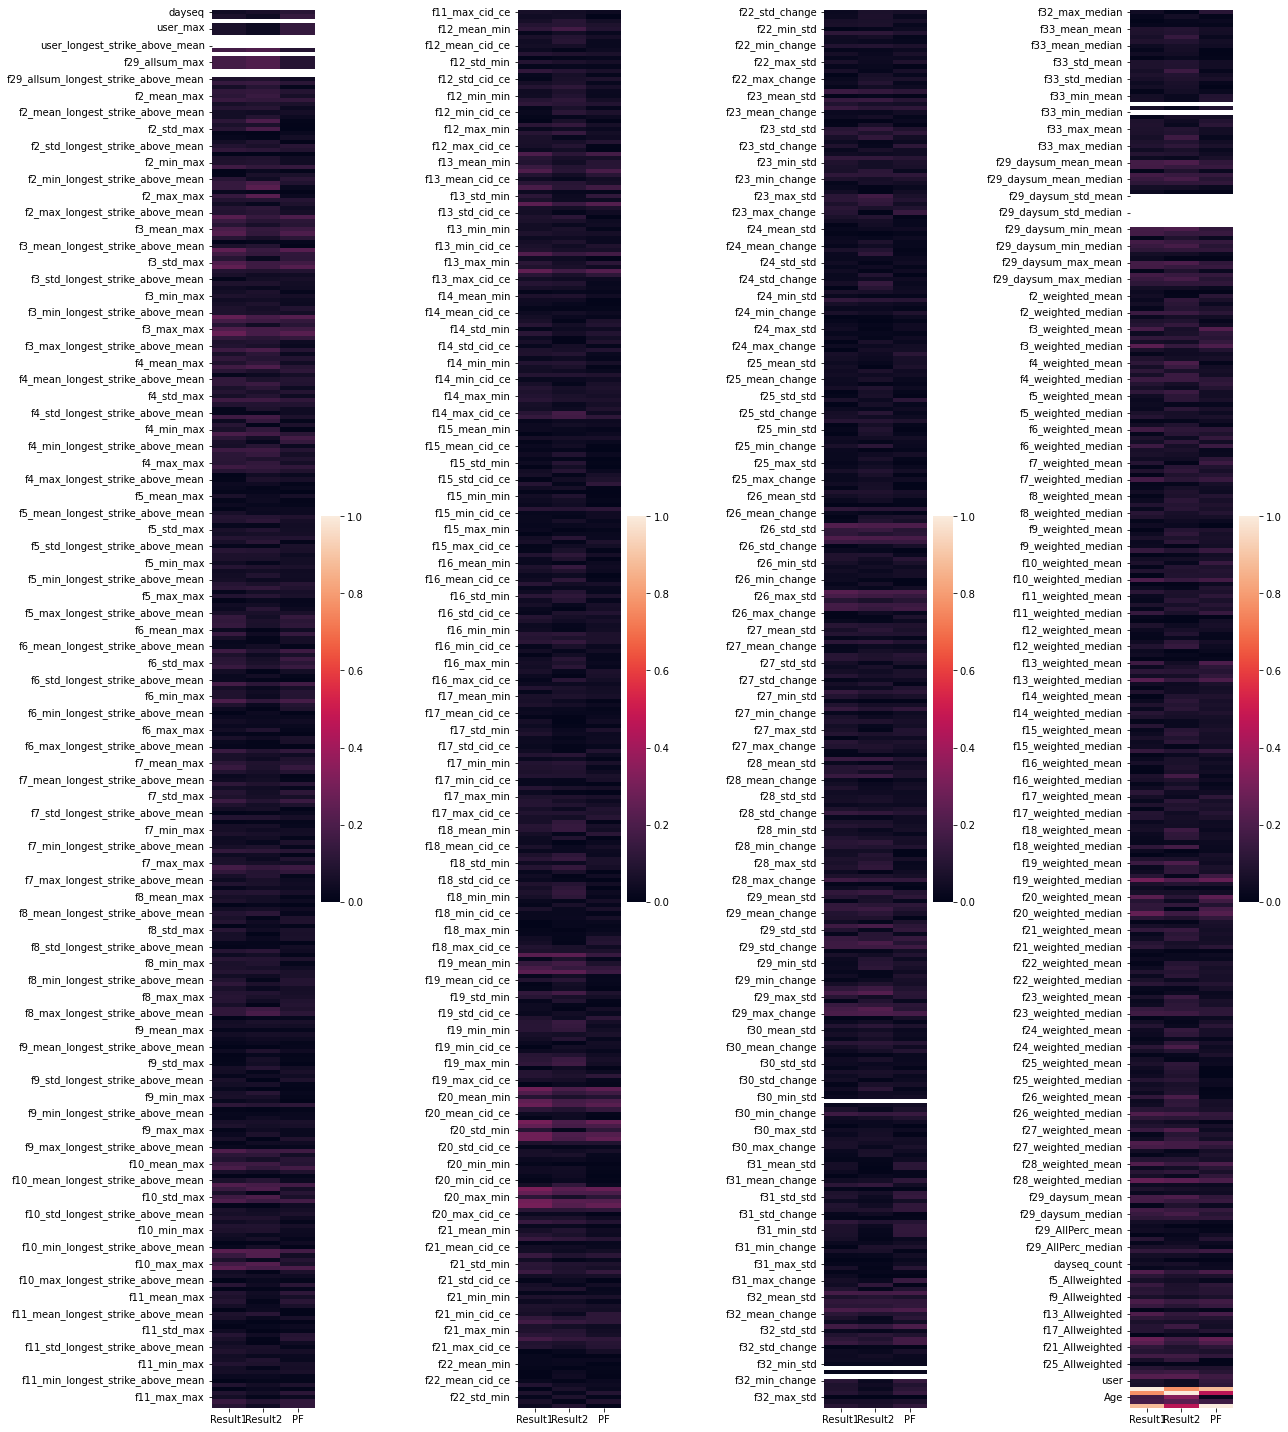

In [10]:
#calculate correlation matrix and store correlations between features and the two SF26 measures (Result1 and Result2)
correlation = summaryMotionQS.drop(['Q' + str(x) for x in range(1,37)],axis=1).corr()[['Result1','Result2','PF']]

#display correlations in number of seperate heatmaps for just Result1 and Result2 to make is easier to view
NUM_SUBPLOTS = 4
fig, axes = plt.subplots(1, NUM_SUBPLOTS, figsize=(18,20))

#for each subplot, plot a segment of the correlation matrix
for i in range(0,NUM_SUBPLOTS):
    sns.heatmap(ax=axes[i],data=correlation.iloc[int(correlation.shape[0]/NUM_SUBPLOTS)*i:int(correlation.shape[0]/NUM_SUBPLOTS)*(i+1),:].abs(),vmin=0, vmax=1)

fig.tight_layout()
plt.show()

### Top 10 Correlations between Result1 (Physical Component Score) and different motion features

In [11]:
topCorrelationsResult1 = summaryMotionQS.drop(['Q' + str(x) for x in range(1,37)],axis=1).corr()[['Result1']].sort_values('Result1',ascending=False).head(10)
topCorrelationsResult1

,Result1
Result1,1.000000
PF,0.876541
Result2,0.771782
f20_max_mean,0.311599
f20_std_mean,0.301933
f20_max_median,0.299125
f19_weighted_median,0.292290
f20_max_max,0.286478
f20_std_max,0.278584
f20_std_median,0.278394


### Top 10 Correlations between Result2 (Mental Component Score) and different motion features

In [12]:
topCorrelationsResult2 = summaryMotionQS.drop(['Q' + str(x) for x in range(1,37)],axis=1).corr()[['Result2']].sort_values('Result2',ascending=False).head(10)
topCorrelationsResult2

,Result2
Result2,1.000000
Result1,0.771782
PF,0.460089
Age,0.334213
f19_mean_median,0.238202
f28_weighted_median,0.237927
f19_mean_mean,0.236695
Gender,0.230805
f2_max_std,0.229681
f2_max_max,0.229118


## Visual analysis of correleation between Result1/Result2 and top 10 correlating features

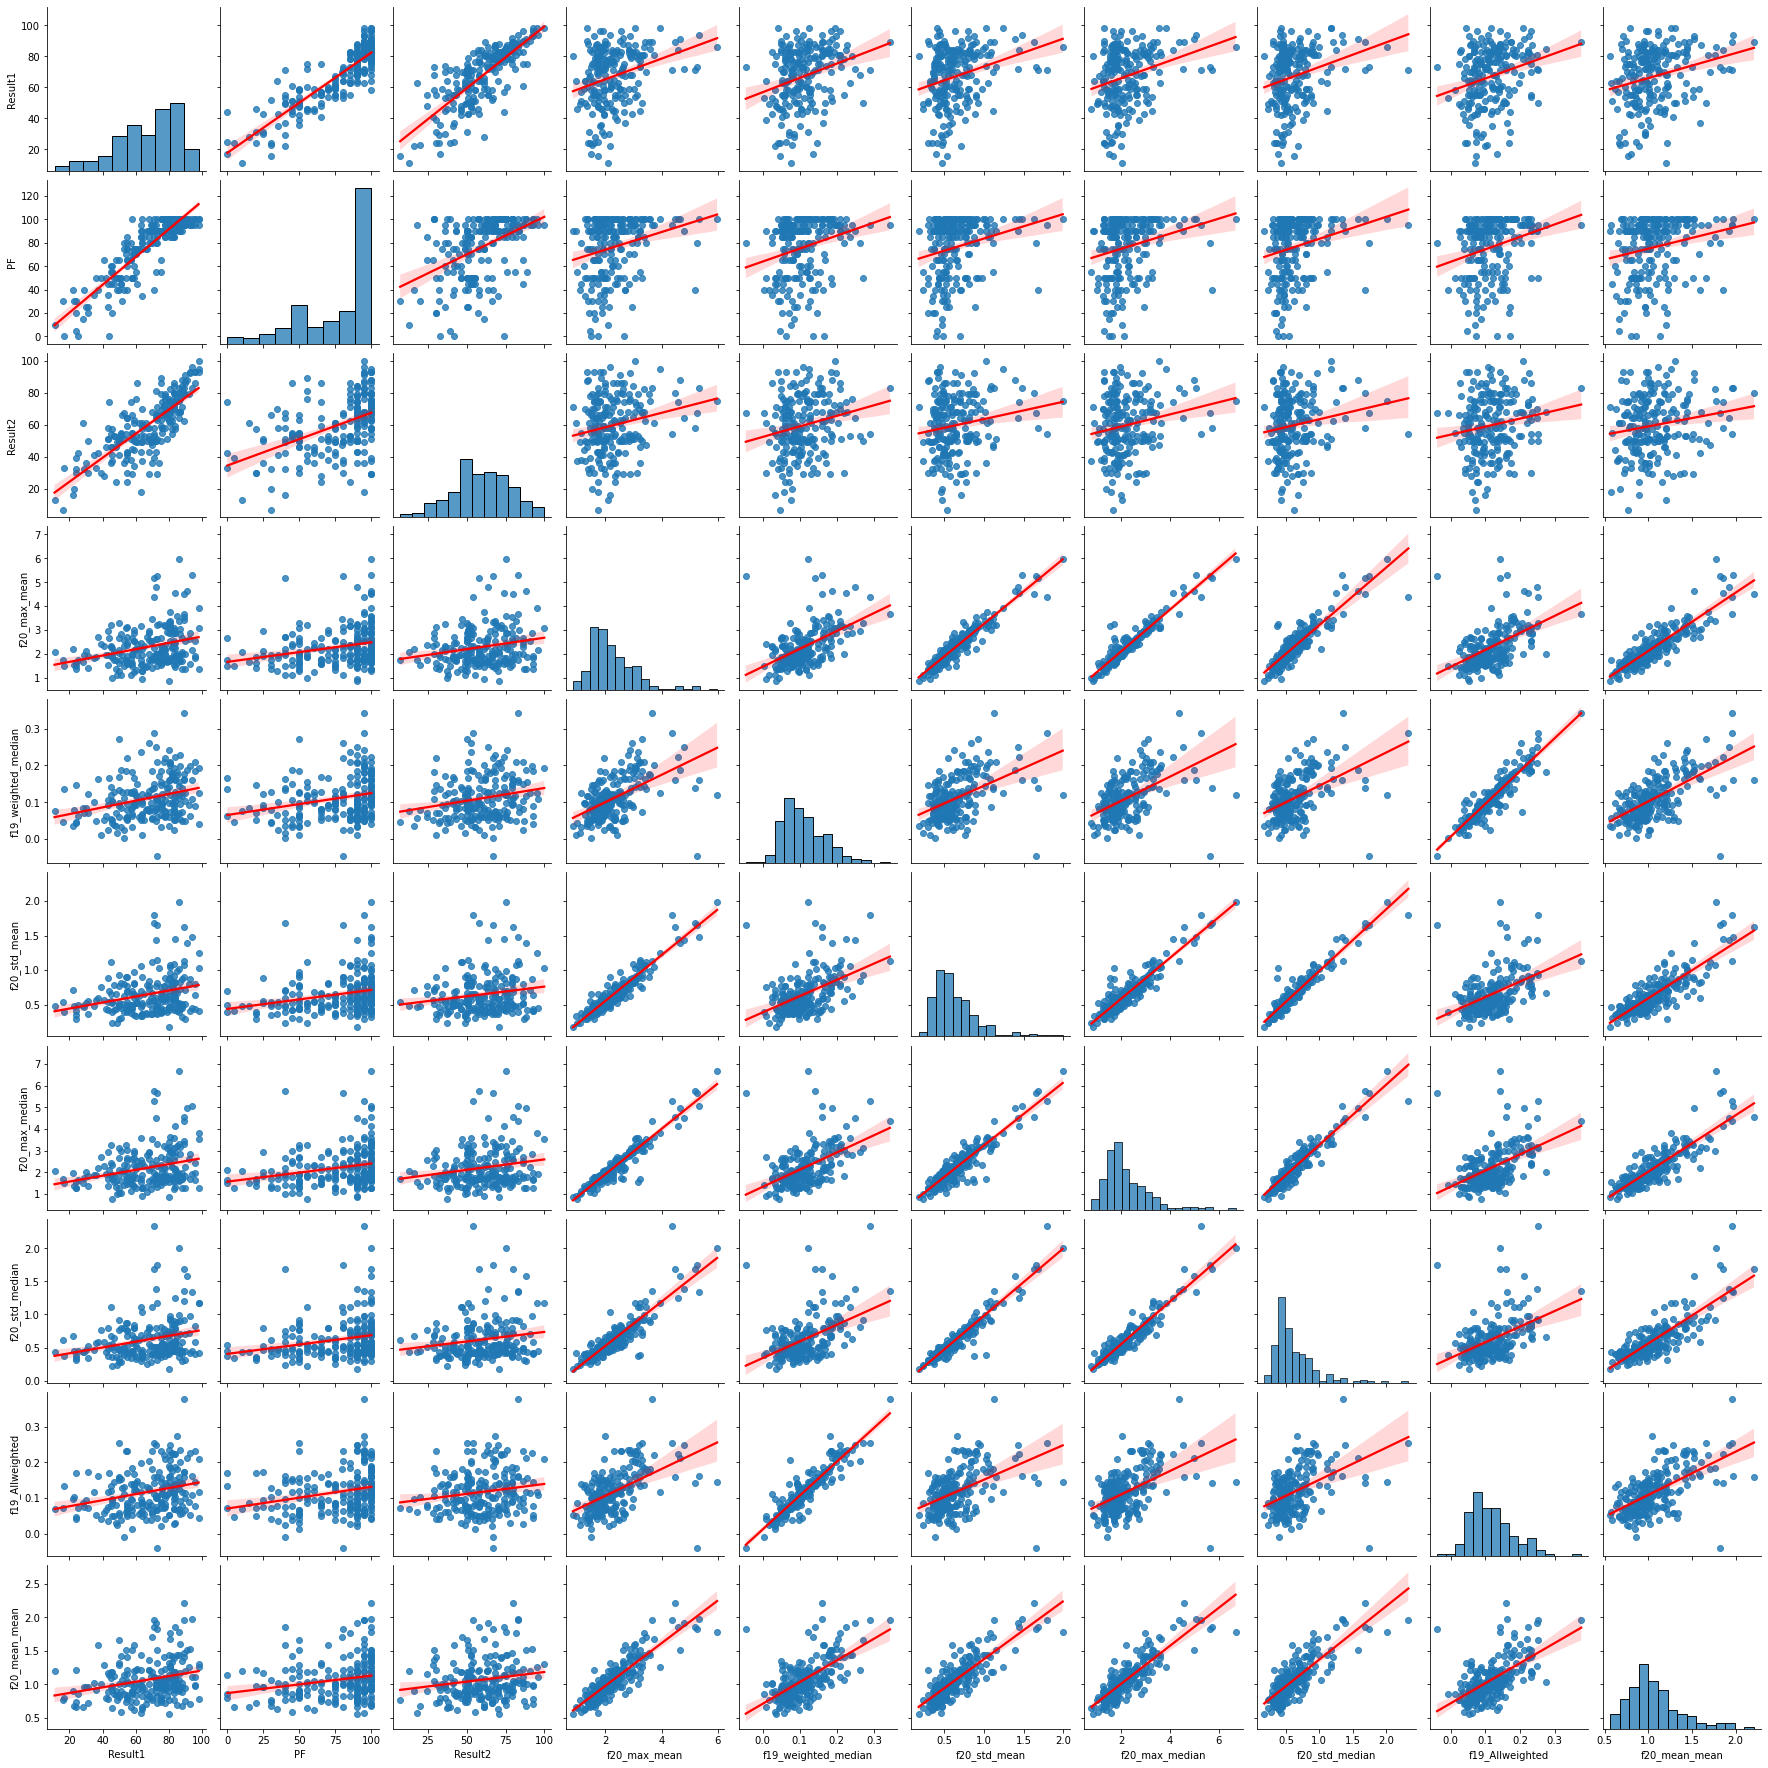

In [12]:
sns.pairplot(summaryMotionQS[topCorrelationsResult1.index.values.tolist()],kind="reg", plot_kws={'line_kws':{'color':'red'}})

## 4. Basic Machine Learning Modelling

#### 4.0 Load required modules

In [12]:
#load require scikit-learn libraries
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
import scipy as sp
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from julearn.model_selection import StratifiedGroupsKFold
from sklearn.feature_selection import RFE, RFECV
from genetic_selection import GeneticSelectionCV
from sklearn.ensemble import IsolationForest
import smogn
import pickle

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

#Function to help with evaluating models
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    
    res = 'Average Error: {:0.4f}'.format(np.mean(errors)) + '\n'
    res += 'Accuracy = {:0.2f}%.'.format(accuracy)
    
    return res

#Function to run a Genetic Algorithm for feature selection
def RunGeneticFeatureSelection(X,y):
    
    
    xgb = XGBRegressor(objective= 'reg:squarederror',booster= 'dart',min_child_weight= 9,max_depth=9,n_estimators=100,gamma=25,random_state = 42,learning_rate=0.03,reg_alpha=1.6,reg_lambda=0.2,
                       colsample_bytree=0.3)

    #selector = RFECV(xgb, min_features_to_select=100, step=25,cv=4,n_jobs=-1)
    selector = GeneticSelectionCV(xgb,cv=8,verbose=1,scoring="neg_mean_absolute_percentage_error",max_features=100,n_population=250,crossover_proba=0.5,mutation_proba=0.2,
            n_generations=100,crossover_independent_proba=0.5,mutation_independent_proba=0.05,tournament_size=3,n_gen_no_change=10,caching=True,
            n_jobs=-1,)

    selector = selector.fit(X, y)
    return selector

def removeOutliers(X,y):
    clf = IsolationForest(random_state=0).fit(X_train)
    y_a = clf.predict(X_train)
    mask = y_a != -1
    return X_train.loc[mask,:], y_train.loc[mask]

#### 4.1 Create the feature vectors X and the dependent variables y
##### If "loadSelectedFeaturesFromFile" is set to true, the pickle file storing a subset of column names will be loaded
##### The subset of column names were previously selected using the GeneticSelectionCV
##### If "loadSelectedFeaturesFromFile" is set to false, the GeneticSelectionCV is run again

In [ ]:
loadSelectedFeaturesFromFile = False
doRemoveOutlier = True
filename = 'geneticFeatures.pickle'

#built feature vector matrix X
#remove the last 46 columns as these are related to the SF36 questionnaire data
X = summaryMotionQS.iloc[:,1:summaryMotionQS.shape[1]-46]
#add age and gender to the feature vectors
X['Age'] = summaryMotionQS['Age']
X['Gender'] = summaryMotionQS['Gender']
#build label matrix y...y has 2 columns, one for Result1 labels and one for Result2 labels. Models can be trained independently on both of these
y = summaryMotionQS['Result1']#Result1 relates to Physical Component Score

if loadSelectedFeaturesFromFile:
    with open(filename , 'rb') as handle:
        b = pickle.load(handle)
    
    #select subset of columns from X as defined by column names b
    X = X[b]
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state =6)
else:
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state =6)
    
    scale = StandardScaler()
    x_ = X#_train
    y_ = y#_train
    X_scale = scale.fit_transform(x_)
    if doRemoveOutlier:
        X_scale, y_ = removeOutliers(X_scale, y_)
        
    selector = RunGeneticFeatureSelection(X_scale,y_)
    
    X_train= selector.transform(X_train)
    X_test = selector.transform(X_test)
    columns = selector.support_

    with open(filename , 'wb') as handle:
        pickle.dump(list(X.iloc[:, columns].columns), handle, protocol=pickle.HIGHEST_PROTOCOL)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                               
0  	250   	[-0.329697 48.728     0.083804]	[  0.010445  28.329173   0.006987]	[-0.367195  1.        0.055973]	[ -0.297551 100.         0.101004]
1  	158   	[-1080.287306    65.884     1080.074812]	[ 3103.704147    31.520256  3103.778086]	[-10000.            3.            0.062333]	[   -0.297551   168.       10000.      ]
2  	137   	[-1760.261704    72.396     1760.067819]	[ 3808.080726    29.147199  3808.170332]	[-10000.           16.            0.067199]	[   -0.297551   162.       10000.      ]
3  	147   	[-1600.263072    71.748     1600.067738]	[ 3665.945742    26.496122  3666.030993]	[-10000.           28.            0.065571]	[   -0.294409   152.       10000.      ]
4  	154   	[-2280.238487    75.232     2280.060323]	[ 4195.296475    27.413321  4195.393299]	[-10000.           37.            0.0623

#### 4.2 Create the model pipeline and paramater grid (to be used in hyperparamater tuning)
##### XGBoost Regressor model will be used initialy

In [39]:
whichModel = "xgb"

if whichModel == "xgb":
    model1 = make_pipeline(StandardScaler(),XGBRegressor(n_estimators=50,random_state = 42))
    param_grid = {
              'xgbregressor__booster': ['dart'],
              'xgbregressor__gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'xgbregressor__learning_rate': [0.0001,0.001,0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7],
              'xgbregressor__max_depth': [5,6,7,8,9,10,11,12,13,14],
              'xgbregressor__n_estimators': [50,100,150,200,250,250,500,600,750,1000],
              'xgbregressor__reg_alpha': [0,0.1,0.2,0.4,0.8,1.0,1.2,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'xgbregressor__reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200,300,400,500],
                "xgbregressor__min_child_weight" : [ 1, 3, 5, 7 ,9],
                 "xgbregressor__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7, 1 ],
                'xgbregressor__objective': ['reg:squarederror']}
elif whichModel == "svm":
    model1 = make_pipeline(RobustScaler(),SVR())
    param_grid = { 
    #'selectkbest__k': [10,25,50,75,100,150,200],
    # Regularization parameter.
    "svr__C": np.logspace(-2, 5, 10),
    # Kernel type
    "svr__kernel": ['rbf'],
    # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    "svr__gamma": np.logspace(-3, 5, 10)
    }

#### 4.3 Perform hyperparamater tuning and select best hyperparamter based on "neg_root_mean_squared_error" score on a Cross-Validated training set
##### Using the test set, make predictions using the model with best hyoerparamater and present evaluation metrics

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Average Error: 13.9290
Accuracy = 76.67%.
{'xgbregressor__reg_lambda': 3.2, 'xgbregressor__reg_alpha': 0.8, 'xgbregressor__objective': 'reg:squarederror', 'xgbregressor__n_estimators': 1000, 'xgbregressor__min_child_weight': 9, 'xgbregressor__max_depth': 12, 'xgbregressor__learning_rate': 0.6, 'xgbregressor__gamma': 0.2, 'xgbregressor__colsample_bytree': 0.4, 'xgbregressor__booster': 'dart'}
-0.29209986734809196

(0.4480419027848242, 0.002587518803463986)


/home/ubuntu/miniconda3/envs/healthu/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


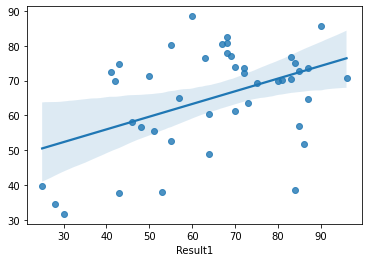

In [41]:
#grid1 = BayesSearchCV(model1,param_grid,scoring='neg_root_mean_squared_error',n_iter=200,cv=10,verbose=1,n_jobs=-1,random_state = 42)
grid1 = RandomizedSearchCV(model1,param_grid,scoring='neg_mean_absolute_percentage_error',n_iter=10,cv=10,verbose=1,n_jobs=-1,random_state = 42)
grid1.fit(X_train,y_train)


test_pred = grid1.best_estimator_.predict(X_test)

res= evaluate(grid1.best_estimator_,X_test,y_test) + '\n'
res += str(grid1.best_params_) + '\n'
res += str(grid1.best_score_) + '\n'
print(res)


with open('xgres.txt', 'w') as f:
    print(res, file=f)
    
sns.regplot(y_test,test_pred)
print(sp.stats.pearsonr(y_test,test_pred))